# EWMA variance

A method for tracking variance over time while giving more importance to recent observations using an exponential decay factor.  

### **Key Ideas**  
- Recent data matters more than older data.  
- Fading factor ( $\alpha$ ) determines how fast older data is "forgotten".
- Variance is updated based on the deviation between the current and previous values.  

### **Mathematical Formulation**  
For a sequence of observations ( $x_t$ ) and initial $weight\_sum = 1$:  

1. **Exponentially Weighted Mean (EWA):**  
   $$
   \text{weight} = (1 - \alpha) \cdot \text{weight\_sum}
   $$
   $$
   \mu_t = \frac{\text{weight} \cdot \mu_{t-1} + x_t}{\text{weight} + 1}
   $$
   where ( $\mu_t$ ) is the exponentially weighted average.  

2. **Exponentially Weighted Variance (EWV):**  
   $$
   \sigma^2_t = \frac{\text{weight} \cdot \sigma^2_{t-1} + (x_t - \mu_{t-1}) (x_t - \mu_t)}{\text{weight} + 1}
   $$
   where ( $\sigma^2_t$ ) is the exponentially weighted variance.  

**Requirements:**

!pip install river

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            }
}
```
![proba_forecast_v2](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v2.png?raw=true)

In [23]:
import os
import pandas as pd
import numpy as np
import math
from pathlib import Path
import matplotlib.pyplot as plt

TEST_DATA_START_TIME = 90000

current_dir = Path.cwd()
PATH_DATA = current_dir.parent.parent.parent / 'data' / 'bird_feed_data.csv'

def local_test_data_generator(path_data=PATH_DATA, chunksize=1000, start_time=TEST_DATA_START_TIME):
    """
    Generate the local test data yielding one record (dict) at a time.

    :param path_data: path to .csv data file
    :param chunksize: Number of rows to read at a time (default is 1000).
    """
    prev_time = start_time
    for chunk in pd.read_csv(path_data, chunksize=chunksize):
        for k, row in chunk.iterrows():
            if k > 500:
                row['time'] = row['time'] / math.pi  # don't ask
                if row['time'] > prev_time:
                    prev_time = row['time']
                    yield row.to_dict()


def remote_test_data_generator(chunksize=1000, start_time=TEST_DATA_START_TIME):
    """
    Generate the remote test data yielding one record (dict) at a time.

    :param chunksize: Number of rows to read at a time (default is 1000).
    """
    url = 'https://raw.githubusercontent.com/microprediction/birdgame/refs/heads/main/data/bird_feed_data.csv'
    prev_time = start_time
    for chunk in pd.read_csv(url, chunksize=chunksize):
        for k, row in chunk.iterrows():
            if k > 500:
                row['time'] = row['time'] / math.pi  # don't ask
                if row['time'] > prev_time:
                    prev_time = row['time']
                    yield row.to_dict()

### Warm up example

In [24]:
from river import stats


class FEWVar(stats.base.Univariate):

    def __init__(self, fading_factor=0.01):
        # Initialize the fading factor and state variables
        self.fading_factor = fading_factor
        self.ewa = None  # Exponentially weighted average (mean)
        self.ewv = None  # Exponentially weighted variance
        self.weight_sum = 0

    def update(self, x):
        # If this is the first data point, set ewa to x and initialize variance
        if self.ewa is None:
            self.ewa = x
            self.ewv = 0  # Variance starts at 0 with one sample
            self.weight_sum = 1
        else:
            # Incrementally update the EWA (mean)
            weight = (1 - self.fading_factor) * self.weight_sum
            previous_ewa = self.ewa
            self.ewa = (weight * self.ewa + x) / (weight + 1)
            self.weight_sum = weight + 1

            # Update the EW variance
            deviation = x - previous_ewa
            self.ewv = (weight * self.ewv + deviation * (x - self.ewa)) / (weight + 1)

    def tick(self, x):
        return self.update(x=x)

    def get(self):
        # Return the current exponentially weighted variance
        return self.ewv if self.ewv is not None else 0

    def get_var(self):
        return self.get()

    def get_mean(self):
        # Return the current exponentially weighted mean (for reference)
        return self.ewa if self.ewa is not None else 0

    def to_dict(self):
        """
        Serializes the state of the FEWVar object to a dictionary.
        """
        return {
            'fading_factor': self.fading_factor,
            'ewa': self.ewa,
            'ewv': self.ewv,
            'weight_sum': self.weight_sum
        }

    @classmethod
    def from_dict(cls, data):
        """
        Deserializes the state from a dictionary into a new FEWVar instance.
        """
        instance = cls(fading_factor=data['fading_factor'])
        instance.ewa = data['ewa']
        instance.ewv = data['ewv']
        instance.weight_sum = data['weight_sum']
        return instance

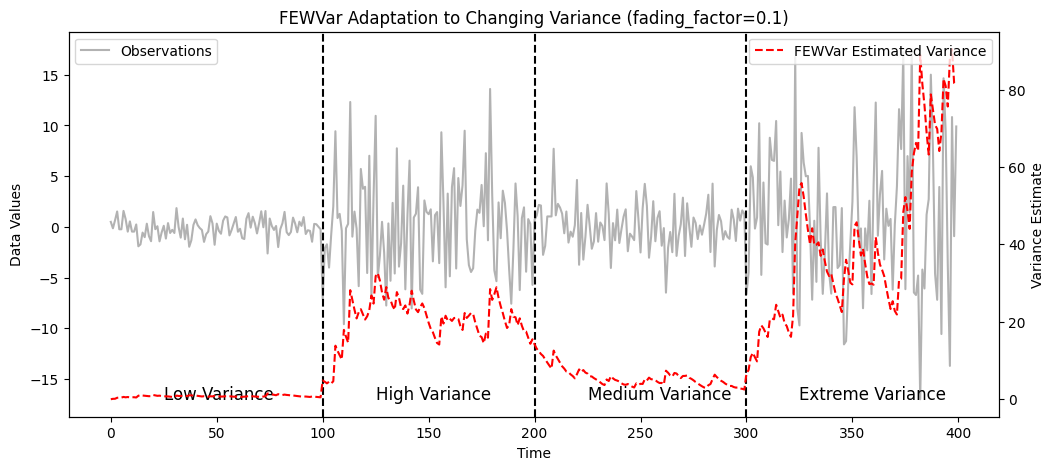

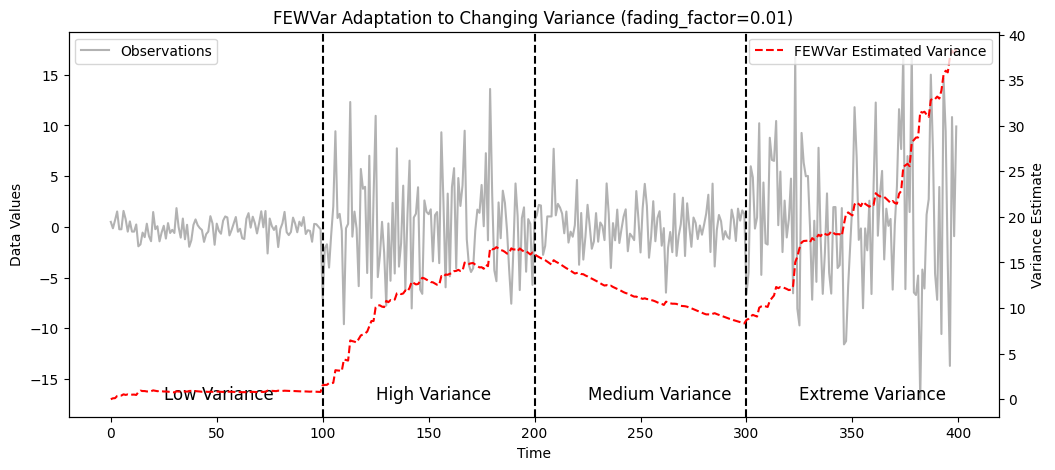

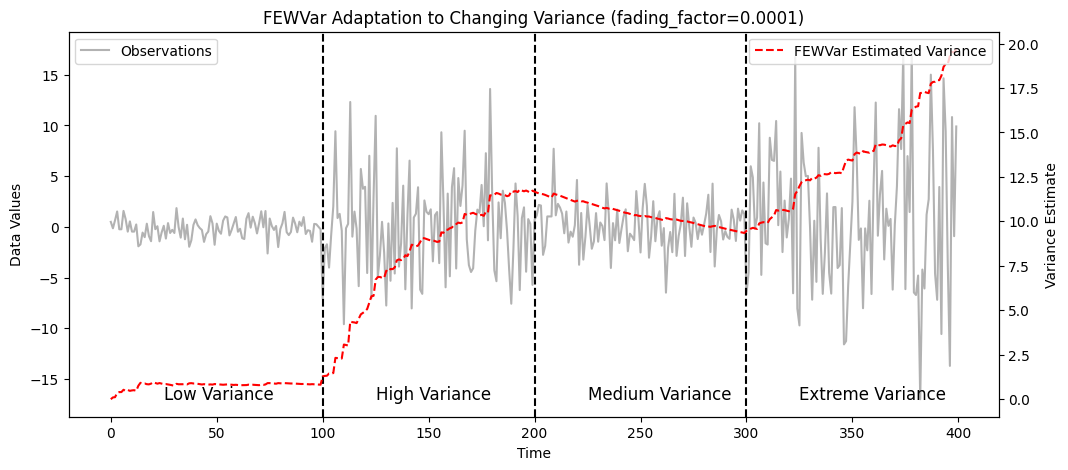

In [25]:
def visualize_fewvar(fading_factor=0.001):
    """ Function to visualize FEWVar adaptation to changing variance """

    # Generate synthetic data with sudden variance shifts
    np.random.seed(42)
    data = np.concatenate([
        np.random.normal(0, 1, 100),    # Low variance phase
        np.random.normal(0, 5, 100),    # High variance jump
        np.random.normal(0, 2, 100),    # Medium variance
        np.random.normal(0, 8, 100),    # Extreme variance
    ])

    # Initialize FEWVar
    ewa_dx = FEWVar(fading_factor=fading_factor)

    variances = []
    # Update FEWVar and store the variance estimates
    for x in data:
        ewa_dx.update(x)
        variances.append(ewa_dx.get())

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot data points
    ax1.plot(data, label="Observations", color="gray", alpha=0.6)
    ax1.set_ylabel("Data Values")
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")

    # Plot variance estimates
    ax2 = ax1.twinx()
    ax2.plot(variances, label="FEWVar Estimated Variance", color="red", linestyle="--")
    ax2.set_ylabel("Variance Estimate")
    ax2.legend(loc="upper right")

    # Add black dashed lines to separate phases
    phase_endpoints = [100, 200, 300]  # Indices where phases change
    for endpoint in phase_endpoints:
        ax1.axvline(x=endpoint, color='black', linestyle='--')
    
    # Annotating the phases in the graph
    ax1.text(25, min(data), 'Low Variance', color='black', fontsize=12)
    ax1.text(125, min(data), 'High Variance', color='black', fontsize=12)
    ax1.text(225, min(data), 'Medium Variance', color='black', fontsize=12)
    ax1.text(325, min(data), 'Extreme Variance', color='black', fontsize=12)

    plt.title(f"FEWVar Adaptation to Changing Variance (fading_factor={fading_factor})")
    plt.show()

# Visualize FEWVar synthetic data on with different fading_factor values
list_fading_factor = [0.1, 0.01, 0.0001]
for factor in list_fading_factor:
    visualize_fewvar(fading_factor=factor)

In [26]:
import math
import numpy as np

class TrackerBase:
    """
    Base class that handles quarantining of data points before they are eligible for processing.
    """
    def __init__(self, horizon: int):
        self.horizon = horizon
        self.quarantine = []
        self.count = 0

    def add_to_quarantine(self, time, value):
        """ Adds a new value to the quarantine list. """
        self.quarantine.append((time + self.horizon, value))

    def pop_from_quarantine(self, current_time):
        """ Returns the most recent valid data point from quarantine. """
        valid = [(j, (ti, xi)) for (j, (ti, xi)) in enumerate(self.quarantine) if ti <= current_time]
        if valid:
            prev_ndx, (prev_t, prev_x) = valid[-1]
            self.quarantine = self.quarantine[prev_ndx+1:]  # Trim the quarantine list
            return prev_t, prev_x
        return None, None



class EMWAVarTracker(TrackerBase):
    """
    A model that fits a mixture of two Gaussian distributions, one capturing the core
    distribution and another with a larger variance to capture the tails.

    Parameters
    ----------
    fading_factor : float
        Parameter controlling how quickly older data is de-emphasized in variance estimation.
    horizon : int
        The "look-ahead" in time after which the recorded data becomes valid for updating.
    """

    def __init__(self, fading_factor=0.0001, horizon=10):
        super().__init__(horizon)
        self.fading_factor = fading_factor
        self.current_x = None
        self.ewa_dx_core = FEWVar(fading_factor=fading_factor)
        self.ewa_dx_tail = FEWVar(fading_factor=fading_factor)
        self.weights = [0.95, 0.05]  # Heavily weight the core distribution

    def tick(self, payload):
        """
        Ingest a new record (payload), store it internally and update the
        estimated Gaussian mixture model.

        The core distribution captures regular variance, while the tail distribution
        captures extreme deviations.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        """

        x = payload['dove_location']
        t = payload['time']
        self.add_to_quarantine(t, x)
        self.current_x = x
        prev_t, prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:
            x_change = x - prev_x

            # Winsorize the update for the core estimator to avoid tail effects
            threshold = 2.0 * math.sqrt(self.ewa_dx_core.get() if self.count > 0 else 1.0)
            if threshold > 0:
                winsorized_x_change = np.clip(x_change, -threshold, threshold)
            else:
                winsorized_x_change = x_change
            self.ewa_dx_core.update(winsorized_x_change)

            # Feed the tail estimator with double the real change magnitude
            self.ewa_dx_tail.update(2.0 * x_change)

            self.count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution,
        modeled as a mixture of two Gaussians.
        """
        x_mean = self.current_x
        components = []

        for i, ewa_dx in enumerate([self.ewa_dx_core, self.ewa_dx_tail]):
            try:
                x_var = ewa_dx.get()
                x_std = math.sqrt(x_var)
            except:
                x_std = 1.0

            if x_std <= 1e-6:
                x_std = 1e-6

            components.append({
                "density": {
                    "type": "builtin",
                    "name": "norm",
                    "params": {"loc": x_mean, "scale": x_std}
                },
                "weight": self.weights[i]
            })

        prediction_density = {
            "type": "mixture",
            "components": components
        }
        return prediction_density

In [27]:
import typing


def train():
    pass


def infer(
    payload_stream: typing.Iterator[dict],
):
    # Parameters
    HORIZON = 10
    FADE_FACTOR = 0.0001

    # Initialize Model
    model = EMWAVarTracker(fading_factor=FADE_FACTOR, horizon=HORIZON)

    yield  # Signal initialization completion

    for payload in payload_stream:
        model.tick(payload)
        yield model.predict()

In [28]:
def compute_pdf_score(past_pdf, observed_dove_location):
    """ Compute weighted PDF score of a normal distribution """
    weighted_pdf_score = 0
    highest_weight = 0
    stored_predictions = []

    for component in past_pdf.get('components', []):
        density = component['density']
        loc, scale, weight = density['params']['loc'], density['params']['scale'], component['weight']

        # Compute PDF score (Gaussian)
        pdf_score = (1 / (math.sqrt(2 * math.pi * scale**2))) * \
                    math.exp(-((observed_dove_location - loc) ** 2) / (2 * scale**2))

        weighted_pdf_score += weight * pdf_score

        # Store prediction with highest weight
        if weight > highest_weight:
            stored_predictions = [(loc, scale, observed_dove_location, pdf_score)]
            highest_weight = weight

    return round(weighted_pdf_score, 3), stored_predictions


def find_past_pdf(pdf_history, current_time, horizon):
    """ Function to find the most recent valid past prediction """
    for past_time, p_pdf in reversed(pdf_history):
        if past_time < current_time - horizon:
            return p_pdf
    return None  # No valid past prediction

In [29]:
import time
import json
from tqdm.auto import tqdm

# Parameters
HORIZON = 10
FADE_FACTOR = 0.0001
MAX_TRACKER_COUNT = 10000
SHOW_PRINT = True
STEP_PRINT = 1000

# Initialize Tracker
tracker = EMWAVarTracker(fading_factor=FADE_FACTOR, horizon=HORIZON)

# History to track evaluation metrics and the PDFs
pdf_score_history = []
pdf_history = []
store_pred = []

# Start Processing Data
start_time = time.time()
if os.path.exists(PATH_DATA):
    data_generator = local_test_data_generator()
else:
    data_generator = remote_test_data_generator()

for payload in tqdm(data_generator, position=0, leave=True):
    try:
        tracker.tick(payload)
        pdf = tracker.predict()
        current_time = payload['time']

        # Store the latest PDF prediction
        pdf_history.append((current_time, pdf))

        # Find past PDF predicition for evaluation
        past_pdf = find_past_pdf(pdf_history, current_time, HORIZON)

        if past_pdf:
            observed_dove_location = payload['dove_location']
            weighted_pdf_score, predictions = compute_pdf_score(past_pdf, observed_dove_location)

            # Store results
            pdf_score_history.append(weighted_pdf_score)
            store_pred.extend([(current_time, *p) for p in predictions])

            if SHOW_PRINT and len(pdf_history) % STEP_PRINT == 0:
                print(
                    f"[{tracker.count}] PDF Score: {weighted_pdf_score:.4f} / true: {observed_dove_location:.4f} / "
                    f"pred: {predictions[0][0]:.4f} / dif: {observed_dove_location - predictions[0][0]:.4f} / "
                    f"scale: {predictions[0][1]:.4f}"
                )
        else:
            if SHOW_PRINT:
                print(f"[{tracker.count}] No valid past PDF for evaluation.")

    except json.JSONDecodeError:
        print(f"[{tracker.count}] Error: Could not parse JSON payload.")

    if tracker.count > MAX_TRACKER_COUNT:
        break

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.2f} seconds")

0it [00:00, ?it/s]

[0] No valid past PDF for evaluation.
[0] No valid past PDF for evaluation.
[523] PDF Score: 13.0830 / true: 8396.0902 / pred: 8396.1007 / dif: -0.0105 / scale: 0.0058
[1065] PDF Score: 34.3180 / true: 8395.4667 / pred: 8395.4600 / dif: 0.0068 / scale: 0.0071
[1597] PDF Score: 43.4220 / true: 8395.8812 / pred: 8395.8787 / dif: 0.0025 / scale: 0.0084
[2114] PDF Score: 29.3540 / true: 8395.0469 / pred: 8395.0548 / dif: -0.0079 / scale: 0.0084
[2630] PDF Score: 40.8940 / true: 8395.6477 / pred: 8395.6440 / dif: 0.0037 / scale: 0.0085
[3140] PDF Score: 0.3940 / true: 8395.7813 / pred: 8395.7502 / dif: 0.0311 / scale: 0.0085
[3692] PDF Score: 42.2200 / true: 8395.7586 / pred: 8395.7586 / dif: 0.0000 / scale: 0.0091
[4234] PDF Score: 39.8570 / true: 8395.0275 / pred: 8395.0296 / dif: -0.0021 / scale: 0.0093
[4726] PDF Score: 0.0200 / true: 8394.8244 / pred: 8394.9810 / dif: -0.1566 / scale: 0.0094
[5319] PDF Score: 34.3800 / true: 8395.1889 / pred: 8395.1937 / dif: -0.0048 / scale: 0.0099
[5

In [30]:
def compute_metric_stats(df):
    """Compute and print median, mean and std of metrics"""
    stats = df.agg(["median", "mean", "std"]).round(3)
    
    for stat_name, values in stats.iterrows():
        print(f"{stat_name.capitalize()}: {values.to_dict()}")

    return stats

skip_length = 500
# Create history score (skipping first 500 values -> skip warmup of model)
scores = pd.DataFrame({"pdf_score": pdf_score_history[skip_length:]})
stats_summary = compute_metric_stats(scores)

pred_summary = pd.DataFrame(store_pred[skip_length:], columns=["time", "loc", "scale", "dove_location", "pdf_score"])
pred_summary.round(4)

Median: {'pdf_score': 33.197}
Mean: {'pdf_score': 26.579}
Std: {'pdf_score': 17.02}


,time,loc,scale,dove_location,pdf_score
0,102671.0,8396.5263,0.0053,8396.5300,59.2457
1,102672.0,8396.5311,0.0053,8396.5121,0.1259
2,102674.0,8396.5311,0.0053,8396.5121,0.1259
3,102685.0,8396.5121,0.0054,8396.5139,70.3654
4,102686.0,8396.5121,0.0054,8396.5285,0.6919
...,...,...,...,...,...
18640,289588.0,8396.0612,0.0103,8396.0507,23.0754
18641,289590.0,8396.0612,0.0103,8396.0479,16.8456
18642,289592.0,8396.0612,0.0103,8396.0450,11.2153
18643,289595.0,8396.0612,0.0103,8396.0431,8.3036


In [31]:
def plot_dove_predictions(store_pred, start_ind=1000, window_size=200, max_pdf_score=100):
    """
    Plots observed vs. predicted dove locations with uncertainty and PDF scores.

    Parameters:
        store_pred (list of tuples): Stored predictions in the format (time, loc, scale, dove_location, pdf_score).
        start_ind (int): Starting index for slicing data.
        window_size (int): Number of points to plot.
        max_pdf_score (float): Maximum value for clipping PDF scores (to prevent extreme values from dominating).
    """
    end_ind = start_ind + window_size
    
    # time, dove_location, predictions and metrics
    data_slice = np.array(store_pred[start_ind:end_ind], dtype=np.float64)
    times, predicted_locs, scales, dove_location, pdf_scores = data_slice.T

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot locations (left y-axis)
    ax1.scatter(times, dove_location, color="grey", label="Observed Dove Location", marker="o", alpha=0.9)
    ax1.plot(times, predicted_locs, label="Predicted Mean (loc)", color="red", linestyle="-")
    ax1.fill_between(times, predicted_locs - scales, predicted_locs + scales, color="red", alpha=0.2, label="±1 Std Dev (Scale)")

    # Left y-axis labels
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Dove Location")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    # Create second right y-axis for metric scores
    ax2 = ax1.twinx()
    ax2.scatter(times, np.clip(pdf_scores, 0, max_pdf_score), label="PDF Scores", color="green", marker="|", alpha=0.2)

    # Right y-axis labels
    ax2.set_ylabel("PDF Score")
    ax2.legend(loc="upper right")

    plt.title("Observed vs. Predicted Dove Location with Uncertainty and PDF Scores")
    plt.show()


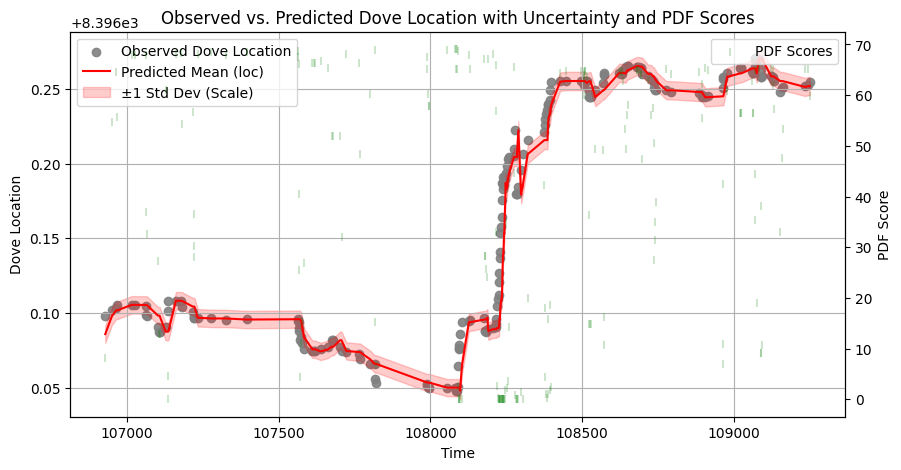

In [32]:
start_ind=1000
window_size=200
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)

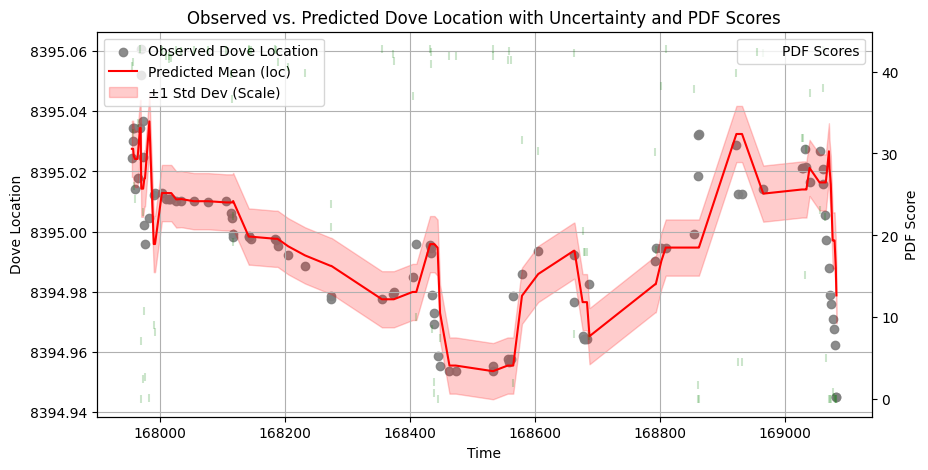

In [33]:
start_ind=8000
window_size=100
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)